In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


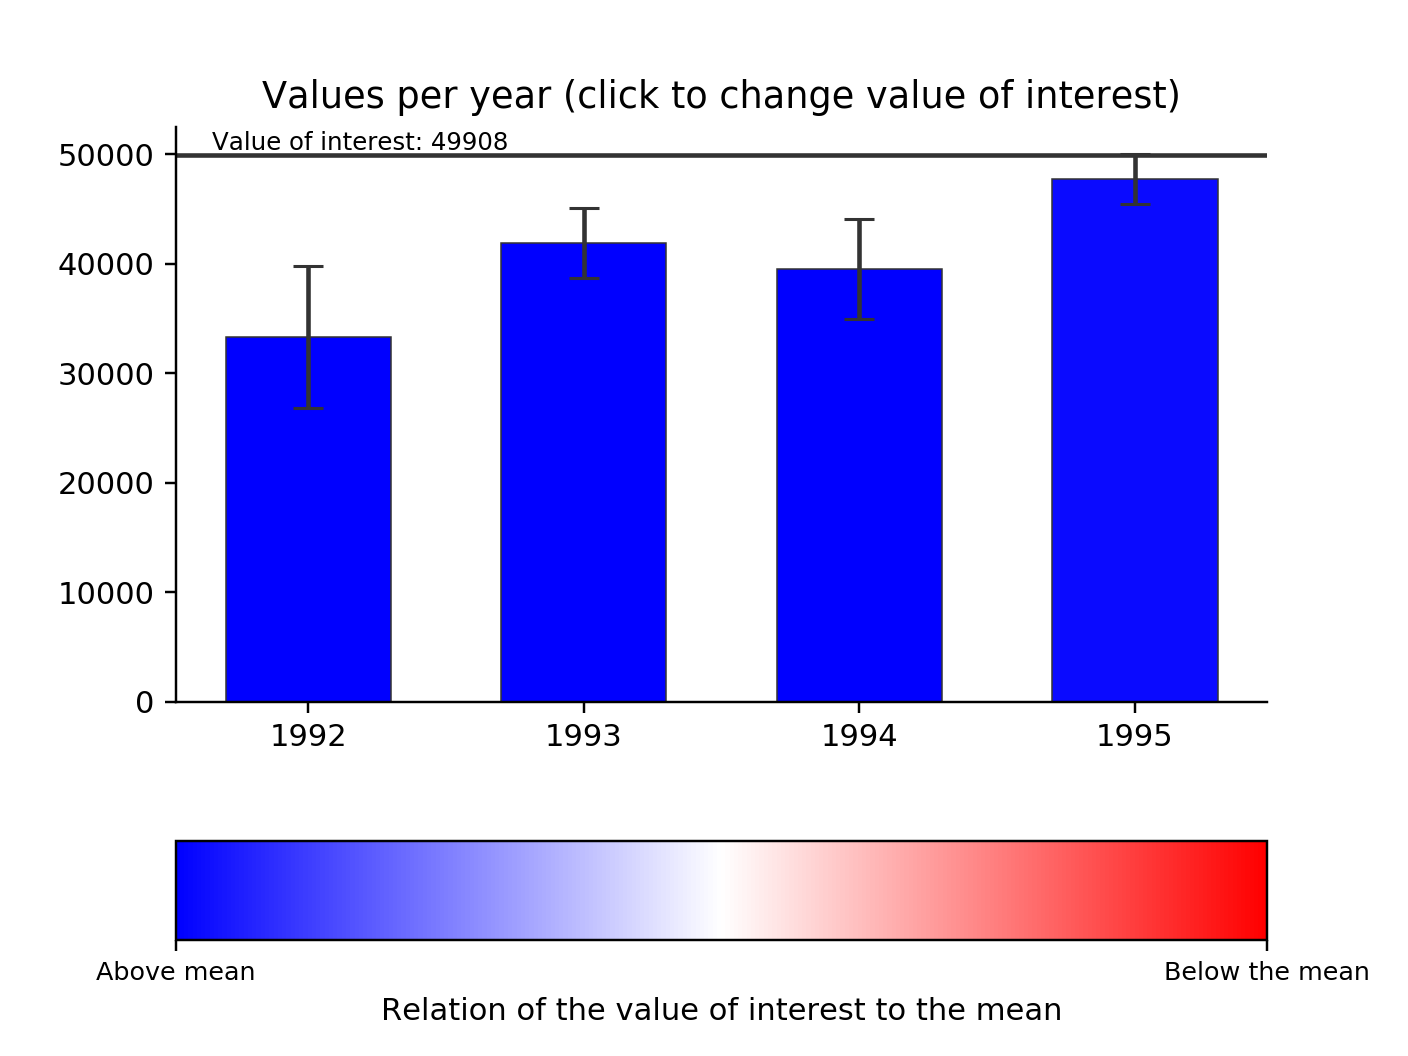

In [3]:
# create base data
np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650),
                   np.random.normal(43000,100000,3650),
                   np.random.normal(43500,140000,3650),
                   np.random.normal(48000,70000,3650)],
                  index=[1992,1993,1994,1995])

# transpose, so years become columns
dft = df.T

# function that returns mean, min value 0.95 confidence, max value 0.95 confidence
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


#dft.describe(include='all')

# create a dataframe with rows = years and columns = mean, cimin, cimax
# values form dataframe can be used to feed to the bar chart
# first create a dict to feed the dataframe
years = ['1992', '1993', '1994', '1995']
yearLen = len(years)
index = np.arange(yearLen)

# create a dict {'1993': pd.Series(all the values for 1993), '1994':... }
seriesPerYear = {}
for i in range(0, yearLen):
    seriesPerYear[years[i]] = dft.iloc[:,i]

# calculate mean, cimin, cimax and add to the dict
ciDict = {'mean':[],'ciMinIntv':[], 'ciMaxIntv':[]}
for s in seriesPerYear.values():
    mn, cimin, cimax = mean_confidence_interval(s)
    ciDict['mean'].append(mn)
    ciDict['ciMinIntv'].append(mn-cimin)
    ciDict['ciMaxIntv'].append(cimax-mn)

# create a dataframe form the dict
#       ciMaxIntv    ciMinIntv          mean
# 1992  6510.938018  6510.938018  33312.107476
# 1993  2264.561291  2264.561291  47743.550969
# 1994  3193.254844  3193.254844  41861.859541
# 1995  4555.329592  4555.329592  39493.304941
cidf = pd.DataFrame(ciDict, index=years)
ciArray = [cidf['ciMinIntv'], cidf['ciMaxIntv']]

# create subplots
fig = plt.figure()
gspec = gridspec.GridSpec(7, 1) # 1 col, 5 rows / put colorbar in row 5
ax = plt.subplot(gspec[:5, 0])
cbax = plt.subplot(gspec[6:, 0])

colorDk = '#333333'
error_kw = {}
cmap = mpl.cm.get_cmap('bwr')

# create color bar
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='horizontal')
cb.set_label('Relation of the value of interest to the mean')
cb.set_ticks([0.0, 1.0])
cb.set_ticklabels(['Above mean', 'Below the mean'])
cb.ax.xaxis.set_tick_params(labelsize='small')

In [4]:
def updatePlot():
    global voi, ax
    ax.cla()

    print(voi)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(years)
    ax.set_title("Values per year (click to change value of interest)")
    ax.text(-0.35, voi+450, "Value of interest: {0:0.0f}".format(voi), fontsize=8)

    plotColors = []
    for y in years:
        # check if voi is under mean-cmin, over mean+xmax or interpollate between
        cimin = cidf.loc[y, 'mean'] - cidf.loc[y, 'ciMinIntv']
        cimax = cidf.loc[y, 'mean'] + cidf.loc[y, 'ciMaxIntv']
        r = (voi - cimin) / (cimax-cimin)
        if r < 0.0:
            rgba = cmap(1.0)
            plotColors.append(rgba)
        elif r > 1.0:
            rgba = cmap(0.0)
            plotColors.append(rgba)
        else: #interpollate
            rgba = cmap(1.0-r)
            plotColors.append(rgba)

    #ax.set_title("{}".format(r))
    print('plot colors:', plotColors)
    ax.bar(index, cidf['mean'], width=0.6, yerr=ciArray, label='',
        color= plotColors,
        edgecolor= colorDk,
        lw=0.5,
        capsize=5,
        ecolor=colorDk
    )
    ax.axhline(voi, color=colorDk)


def clear(event):
    print('clearing')
    global voi, ax
    ax.cla()


def onclick(event):
    global voi
    voi = event.ydata
    updatePlot()


cid = fig.canvas.mpl_connect('button_press_event', onclick)
# cid = fig.canvas.mpl_connect('button_release_event', onclick)


# set initial value of interest
voi = 40000
updatePlot()


40000
plot colors: [(0.0, 0.0, 1.0, 1.0), (1.0, 0.4156862745098039, 0.4156862745098039, 1.0), (0.8862745098039215, 0.8862745098039215, 1.0, 1.0), (1.0, 0.0, 0.0, 1.0)]
